In [1]:
import os
from collections import defaultdict

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import utils
from rasterstats import zonal_stats

plt.style.use("ggplot")

In [2]:
# Connect to PostGIS
eng = nivapy.da.connect_postgis()

Connection successful.


# TEOTIL2 Metals

**Note:** This notebook uses catchment data from NIVA's JupyterHub and should be run there.

## Part 1: Spatial interpolation and regression

For TEOTIL2 Metals, we will assume that metals in freshwaters come from three possible sources:

 * Point inputs from industry, renseanlegg, fish farms etc.
 * Diffuse inputs from atmostpheric deposition
 * Diffuse inputs from geological weathering
 
Extending TEOTIL2 to include metals requires deriving two main parameters for each metal:

 1. **Export coefficients** to convert concentrations measured in mosses (assumed to reflect atmospheric deposition) into actual deposition inputs to water bodies, and 
 
 2. **Retention factors** for each catchment, describing how much of the material added from point, geological and atmospheric souces is retained in each catchment (and how much is transmitted downstream)
 
Initial development of TEOTIL2 Metals (documented [here](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/nope_metals_3.ipynb)) attempted to derive export coefficients by comparing the moss and geological datasets to water chemistry data from the **1995 "1000 Lakes" survey**. However, for most metals, the proportion of samples from the 1995 survey with values at or **below the limit of detection (LOD)** is very high, making it impossible to identify robust relationships. Development of TEOTIL2 Metals was therefore postponed for one year, in anticipation of a new "1000 Lakes" survey with lower LODs scheduled for autumn 2019.

The **2019 1000 Lakes** dataset provides a comprehensive and up-to-date picture of metal concentrations across Norway. This notebook repeats some of the preliminary analysis using the new dataset. The aims are to:

 1. Interpolate the moss and geochemical datasets onto a common grid for comparison
 
 2. For each of the "1000 Lakes" catchments, calculate "zonal statistics" summarising mean moss and geochemical concentrations
 
 3. Explore statistical relationships relating metal concentrations measured in lakes in 2019 to the moss and geochemistry datasets

## 1. Define common grid for spatial interpolation

In [3]:
# Define co-ord system
crs = ccrs.AlbersEqualArea(
    central_longitude=15,
    central_latitude=65,
    false_easting=650000,
    false_northing=800000,
    standard_parallels=(55, 75),
)

# Set up grid
cell_size = 1000  # metres

# Extent
xmin = 0
xmax = 1300000
ymin = 0
ymax = 1600000
extent = [xmin, xmax, ymin, ymax]

# Set up grid for interpolation
# Shift by (cell_size/2) s.t. values are estimated for the centre of each grid square
gridx = np.arange(xmin, xmax, cell_size) + (cell_size / 2.0)
gridy = np.arange(ymin, ymax, cell_size) + (cell_size / 2.0)

# Get Natural Earth data
land_50m = cfeature.NaturalEarthFeature(
    category="cultural",
    name="admin_0_countries",
    scale="50m",
    edgecolor="black",
    facecolor=cfeature.COLORS["land"],
)

sea_50m = cfeature.NaturalEarthFeature(
    category="physical",
    name="ocean",
    scale="50m",
    edgecolor="none",
    facecolor=cfeature.COLORS["water"],
    alpha=1,
)

country_shp = cartopy.io.shapereader.natural_earth(
    resolution="50m", category="cultural", name="admin_0_countries"
)

## 2. Spatially interpolate moss data

Moss surveys are conducted every 5 years, but the number of sites sampled in recent years has been reduced substantially. The most comprehensive survey in terms of the number of data points and use if modern analytical methods (i.e. low LODs) seems to be from 2005. This dataset is used below. 

**Note:** Parameters used for the spatial interpolation algorithm below are taken from the preliminary analysis.

In [4]:
# Read moss data
year = 2005
moss_par_list = ["As", "Cd", "Cr", "Cu", "Hg", "Ni", "Pb", "Zn"]
moss_xlsx = r"../data/metals/mosses/moss_data_tidied.xlsx"
moss_df = pd.read_excel(moss_xlsx, sheet_name="mosses_%s" % year)
moss_df[moss_df < 0] = 0

for par in moss_par_list:
    print(f"Processing: {year} {par.capitalize()}")
    par = par.lower()
    df = moss_df[["lat", "lon", par]].dropna(how="any")

    # Map (long, lat) to projected (x, y) and reformat to syntax required
    # by interp algorithms
    pts = crs.transform_points(
        src_crs=ccrs.PlateCarree(), x=df["lon"].values, y=df["lat"].values
    )[:, :2]

    # Get values to interpolate
    vals = df[par].values

    # IDW interpolation
    idw = nivapy.spatial.interp_idw(pts, vals, gridx, gridy, n_near=8, p=2)

    # Save output
    idw_path = f"../data/metals/mosses/moss_{par}_{year}_mgpkg_idw_n8_p2.tif"
    nivapy.spatial.array_to_gtiff(
        xmin,
        ymax,
        cell_size,
        idw_path,
        idw,
        crs.proj4_init,
        no_data_value=-9999,
        bit_depth="Float32",
    )

Processing: 2005 As
Processing: 2005 Cd
Processing: 2005 Cr
Processing: 2005 Cu
Processing: 2005 Hg
Processing: 2005 Ni
Processing: 2005 Pb
Processing: 2005 Zn


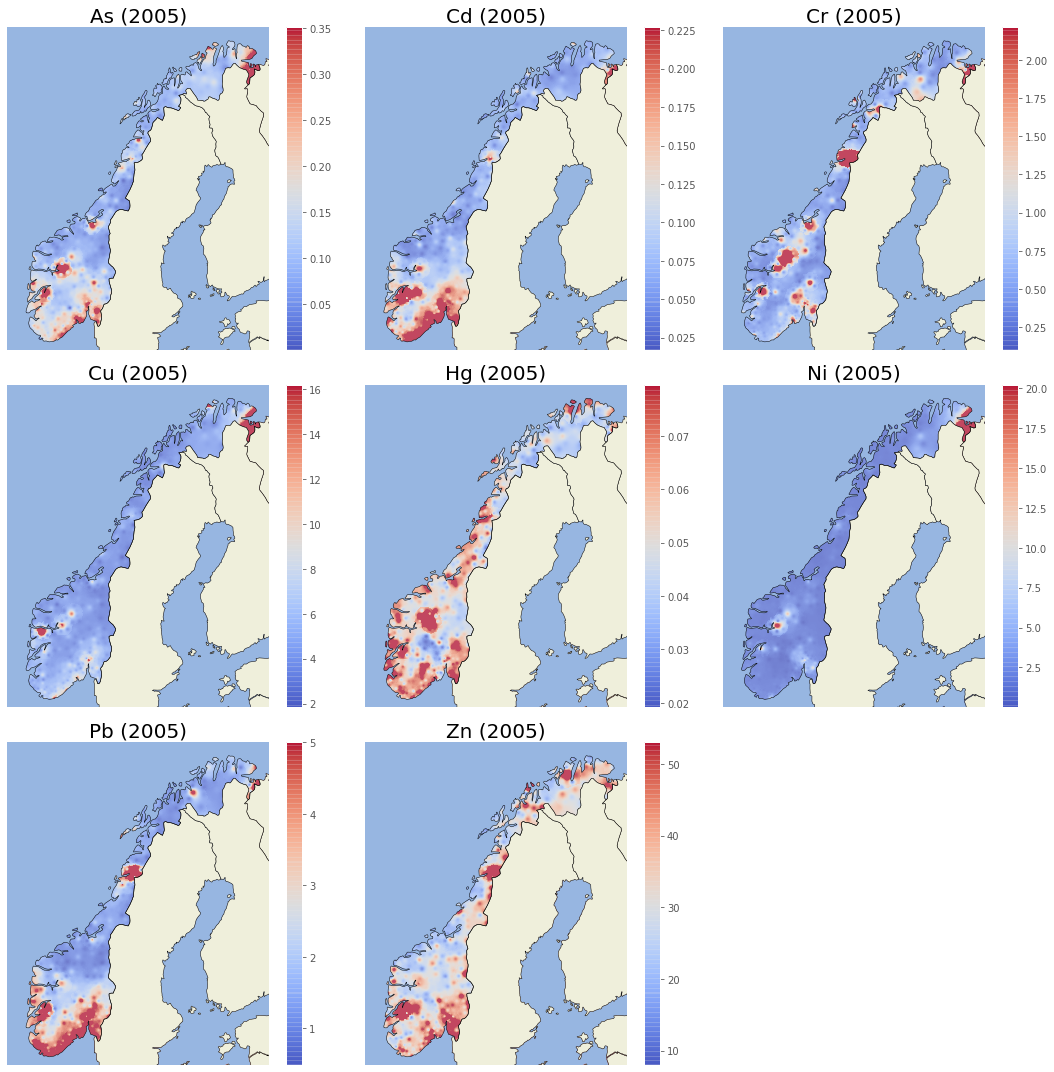

In [5]:
# Setup fig
fig = plt.figure(figsize=(15, 15))

# Loop over data
for idx, par in enumerate(moss_par_list):
    # Read data
    gtiff_path = f"../data/metals/mosses/moss_{par.lower()}_{year}_mgpkg_idw_n8_p2.tif"
    data = nivapy.spatial.read_raster(gtiff_path, band_no=1)[0]

    # Plot
    ax = fig.add_subplot(3, 3, idx + 1, projection=crs)
    ax.set_extent(extent, crs=crs)
    ax.set_title("%s (%s)" % (par.capitalize(), year), fontsize=20)
    cax = ax.imshow(
        data,
        zorder=1,
        extent=extent,
        cmap="coolwarm",
        alpha=0.7,
        interpolation="none",
        vmax=np.nanpercentile(data, 95),
    )

    # Add colourbar
    cbar = fig.colorbar(cax)

    # Make Norway "hollow" so interpolated vaues are visible.
    # Make everywhere else opaque to mask wildly extrapolated values
    reader = cartopy.io.shapereader.Reader(country_shp)
    countries = reader.records()
    for country in countries:
        if country.attributes["NAME"] == "Norway":
            # Transparent
            ax.add_geometries(
                [country.geometry],
                ccrs.PlateCarree(),  # CRS of Natural Earth data
                facecolor="none",
                edgecolor="black",
                zorder=5,
            )
        else:
            # Opaque
            ax.add_geometries(
                [country.geometry],
                ccrs.PlateCarree(),  # CRS of Natural Earth data
                facecolor=cfeature.COLORS["land"],
                edgecolor="black",
                zorder=5,
            )

    # Add sea
    ax.add_feature(sea_50m, zorder=4)

plt.tight_layout()

# Save
out_path = f"../plots/metals/mosses/mosses_{year}_idw_n8_p2.png"
plt.savefig(out_path, dpi=300)

## 3. Spatially interpolate geochemistry data

The workflow below is taken from the preliminary analysis.

In [6]:
# Read geo data
geo_xlsx = r"../data/metals/geochemistry/ngu_geochem_tidied.xlsx"
geo_df = pd.read_excel(geo_xlsx, sheet_name="nitric_acid")
del geo_df["date"], geo_df["from_depth"], geo_df["to_depth"]

# Loop over pars
geol_par_list = ["As", "Cr", "Cu", "Ni", "Pb", "Zn"]

for par in geol_par_list:
    print(f"Processing: {par}")

    par = par.lower()
    df = geo_df[["lat", "lon", par]].dropna(how="any")

    # Map (long, lat) to projected (x, y) and reformat to syntax required
    # by interp algorithms
    pts = crs.transform_points(
        src_crs=ccrs.PlateCarree(), x=df["lon"].values, y=df["lat"].values
    )[:, :2]

    # Get values to interpolate
    vals = df[par].values

    # IDW interpolation
    idw = nivapy.spatial.interp_idw(pts, vals, gridx, gridy, n_near=20, p=1)

    # Save output
    idw_path = f"../data/metals/geochemistry/geochem_{par}_mgpkg_idw_n20_p1.tif"
    nivapy.spatial.array_to_gtiff(
        xmin,
        ymax,
        cell_size,
        idw_path,
        idw,
        crs.proj4_init,
        no_data_value=-9999,
        bit_depth="Float32",
    )

Processing: As
Processing: Cr
Processing: Cu
Processing: Ni
Processing: Pb
Processing: Zn


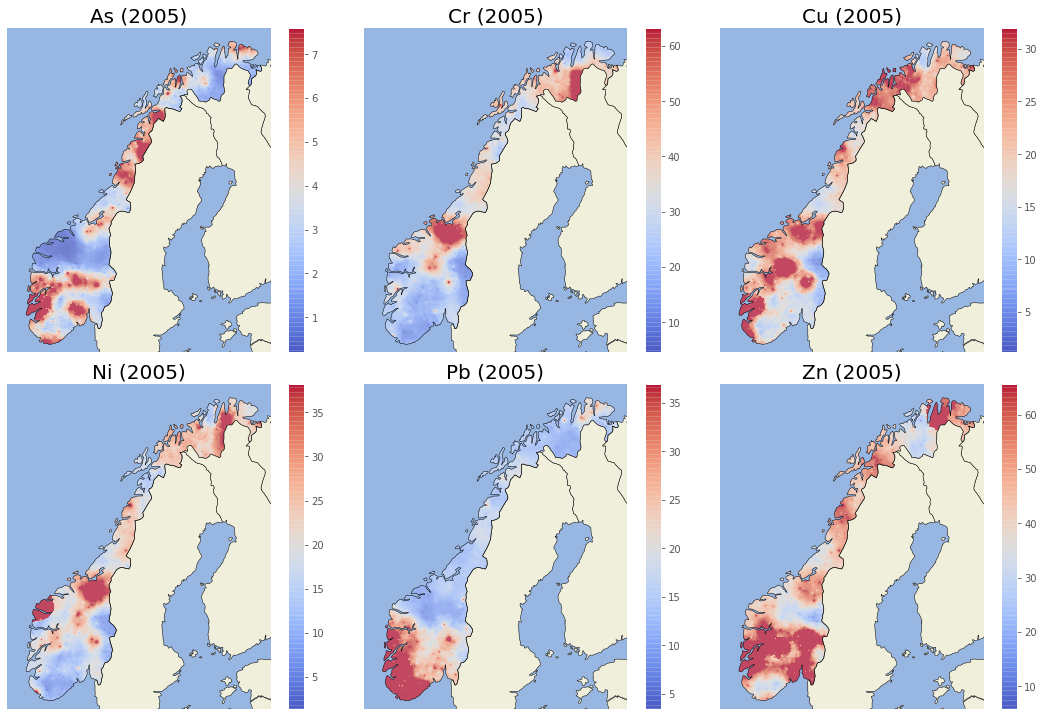

In [7]:
# Setup fig
fig = plt.figure(figsize=(15, 15))

# Loop over data
for idx, par in enumerate(geol_par_list):
    # Read data
    gtiff_path = (
        f"../data/metals/geochemistry/geochem_{par.lower()}_mgpkg_idw_n20_p1.tif"
    )
    data = nivapy.spatial.read_raster(gtiff_path, band_no=1)[0]

    # Plot
    ax = fig.add_subplot(3, 3, idx + 1, projection=crs)
    ax.set_extent(extent, crs=crs)
    ax.set_title("%s (%s)" % (par.capitalize(), year), fontsize=20)
    cax = ax.imshow(
        data,
        zorder=1,
        extent=extent,
        cmap="coolwarm",
        alpha=0.7,
        interpolation="none",
        vmax=np.nanpercentile(data, 95),
    )

    # Add colourbar
    cbar = fig.colorbar(cax)

    # Make Norway "hollow" so interpolated vaues are visible.
    # Make everywhere else opaque to mask wildly extrapolated values
    reader = cartopy.io.shapereader.Reader(country_shp)
    countries = reader.records()
    for country in countries:
        if country.attributes["NAME"] == "Norway":
            # Transparent
            ax.add_geometries(
                [country.geometry],
                ccrs.PlateCarree(),  # CRS of Natural Earth data
                facecolor="none",
                edgecolor="black",
                zorder=5,
            )
        else:
            # Opaque
            ax.add_geometries(
                [country.geometry],
                ccrs.PlateCarree(),  # CRS of Natural Earth data
                facecolor=cfeature.COLORS["land"],
                edgecolor="black",
                zorder=5,
            )

    # Add sea
    ax.add_feature(sea_50m, zorder=4)

plt.tight_layout()

# Save
out_path = f"../plots/metals/geochemistry/geochem_idw_n20_p1.png"
plt.savefig(out_path, dpi=300)

## 4. Process 1000 Lakes dataset

### 4.1 Read 2019 water chemistry

In [8]:
wc_df = pd.read_csv(r"../data/metals/1k_lakes/1k_lakes_2019_metals_toc_ph.csv")
del wc_df["station_id"], wc_df["station_name"]
stn_df = pd.read_csv(r"../data/metals/1k_lakes/1k_stations.csv")
del stn_df["name"]
wc_df = pd.merge(stn_df, wc_df, how="inner", on="station_code")
wc_df.head()

,station_id,station_code,station_name,latitude,longitude,altitude,sample_date,As_µg/l,Cd_µg/l,Cr_µg/l,Cu_µg/l,Hg_ng/l,Ni_µg/l,Pb_µg/l,Zn_µg/l,TOC_mg C/l,pH_
0,3167,620-4-6,Ørteren,60.470,7.795,1147.0,2019-10-03,0.034,0.005,0.05,0.19,0.27,0.47,0.010,2.30,0.93,6.75
1,3168,621-1-27,Flåvatna,60.200,9.183,855.0,2019-10-23,0.130,0.006,0.18,0.12,2.67,0.26,0.086,1.70,8.30,6.72
2,3169,621-3-5,Soneren,60.061,9.545,104.0,2019-10-23,0.170,0.013,0.20,0.48,2.51,0.35,0.150,3.30,8.70,6.09
3,3170,622-2-43,Trytetjern,60.213,9.764,275.0,2019-10-23,0.180,0.015,0.28,0.47,3.31,0.62,0.130,4.00,10.50,5.99
4,3171,622-4-4,Krøderen,60.327,9.645,133.0,2019-10-23,0.086,0.004,0.05,0.40,1.08,0.28,0.031,0.93,3.00,6.77


### 4.2. Get catchment boundaries

The 1000 Lakes catchment boundaries are stored on NIVA's JupyterHub.

In [9]:
# Show projects in database
with pd.option_context("display.max_colwidth", -1):
    proj_df = nivapy.da.select_jhub_projects(eng)
    display(proj_df)

,project_id,project_code,project_name,aquamonitor_id,contact,description
0,1,Refelv_Over,Overvåking av referanseelver,11226.0,None,Overvåking av referanseelver
1,2,190246,CL Vestland,NaN,KAU,Critical loads calculations for Vestland
2,4,O-190091,Nasjonal Innsjøundersøkelse 2019,12433.0,HIN,1000 Lakes survey in 2019


In [10]:
# Get catchment data for 1000 Lakes 2019
_, cat_gdf = nivapy.da.select_jhub_project_catchments([4], eng)

cat_gdf.head()

,station_id,station_code,station_name,aquamonitor_id,longitude,latitude,geom
0,259,221-1-2,Langtjern,26070,11.850610,59.809915,"MULTIPOLYGON (((11.85402 59.81418, 11.85437 59..."
1,260,101-2-7,Hokksjøen,26071,11.559946,59.005125,"MULTIPOLYGON (((11.59333 59.01263, 11.59351 59..."
2,261,402-2-13,Sætertjern,26072,12.443670,60.057771,"MULTIPOLYGON (((12.43744 60.07300, 12.43815 60..."
3,262,419-1-25,Mjøgsjøen,26073,11.845276,60.332035,"MULTIPOLYGON (((11.83902 60.33438, 11.84010 60..."
4,263,425-2-2,Kottern,26074,12.511994,60.587319,"MULTIPOLYGON (((12.51086 60.59991, 12.51195 60..."


## 5. Zonal statistics

The code in this section summarises the moss and geochemical datasets for each of the 1000 Lakes catchments.

### 5.1. Moss data

In [11]:
df_list = []
for par in moss_par_list:
    par = par.lower()
    ras_path = f"../data/metals/mosses/moss_{par.lower()}_{year}_mgpkg_idw_n8_p2.tif"

    # Temporary nearest-neighbour resampling to 250 m (as some cacthments are so small that
    # they do not contain any cell centres at 1000 m)
    data = nivapy.spatial.read_raster(ras_path, band_no=1)[0]
    data = nivapy.spatial.rebin_array(data, 4)  # 1000 m to 250 m
    tmp_path = "temp_ras.tif"
    nivapy.spatial.array_to_gtiff(
        xmin,
        ymax,
        250,
        tmp_path,
        data,
        crs.proj4_init,
        no_data_value=-9999,
        bit_depth="Float32",
    )

    # Zonal stats
    stats = zonal_stats(
        cat_gdf["geom"].to_crs(crs.proj4_init), tmp_path, stats=["mean"]
    )
    stats = pd.DataFrame(stats)
    stats.rename({"mean": f"moss_mean_{par}"}, inplace=True, axis="columns")
    df_list.append(stats)

    os.remove(tmp_path)

moss_stats = pd.concat(df_list, axis="columns")
moss_stats["station_code"] = cat_gdf["station_code"]

moss_stats.head()

,moss_mean_as,moss_mean_cd,moss_mean_cr,moss_mean_cu,moss_mean_hg,moss_mean_ni,moss_mean_pb,moss_mean_zn,station_code
0,0.205775,0.154134,1.010850,5.053590,0.067762,2.492166,4.053679,48.575745,221-1-2
1,0.239077,0.208722,1.073517,5.223368,0.080691,1.603577,4.486207,46.403478,101-2-7
2,0.121883,0.123562,0.491291,4.708909,0.072674,1.346237,6.163289,41.311824,402-2-13
3,0.153234,0.174659,0.669890,5.560876,0.071119,1.461035,3.271321,39.771472,419-1-25
4,0.078318,0.110870,0.326235,4.447202,0.036247,0.875804,2.527145,69.301830,425-2-2


### 5.2. Geochemistry data

In [12]:
df_list = []
for par in geol_par_list:
    par = par.lower()
    ras_path = f"../data/metals/geochemistry/geochem_{par.lower()}_mgpkg_idw_n20_p1.tif"

    # Temporary nearest-neighbour resampling to 250 m (as some cacthments are so small that
    # they do not contain any cell centres at 1000 m)
    data = nivapy.spatial.read_raster(ras_path, band_no=1)[0]
    data = nivapy.spatial.rebin_array(data, 4)  # 1000 m to 250 m
    tmp_path = "temp_ras.tif"
    nivapy.spatial.array_to_gtiff(
        xmin,
        ymax,
        250,
        tmp_path,
        data,
        crs.proj4_init,
        no_data_value=-9999,
        bit_depth="Float32",
    )

    stats = zonal_stats(
        cat_gdf["geom"].to_crs(crs.proj4_init), tmp_path, stats=["mean"]
    )
    stats = pd.DataFrame(stats)
    stats.rename({"mean": f"geol_mean_{par}"}, inplace=True, axis="columns")
    df_list.append(stats)

    os.remove(tmp_path)

geol_stats = pd.concat(df_list, axis="columns")
geol_stats["station_code"] = cat_gdf["station_code"]

geol_stats.head()

,geol_mean_as,geol_mean_cr,geol_mean_cu,geol_mean_ni,geol_mean_pb,geol_mean_zn,station_code
0,2.217271,23.179072,12.345365,16.088905,19.512156,53.437241,221-1-2
1,3.354453,26.314884,13.904351,17.814266,24.679426,65.907973,101-2-7
2,1.768443,15.594086,9.057458,9.993840,15.617288,39.293819,402-2-13
3,1.909312,16.113569,9.637932,9.877096,16.759556,37.068876,419-1-25
4,2.860982,13.375097,8.961991,8.342037,17.743345,47.955211,425-2-2


## 6. Combine datasets

In [13]:
# Link water chem, moss and geol datasets
stats = pd.merge(moss_stats, geol_stats, how="inner", on="station_code")
df = pd.merge(wc_df, stats, how="inner", on="station_code")

# Convert pH to [H+]
df["hp"] = 10 ** (-df["pH_"])

df.head()

,station_id,station_code,station_name,latitude,longitude,altitude,sample_date,As_µg/l,Cd_µg/l,Cr_µg/l,...,moss_mean_ni,moss_mean_pb,moss_mean_zn,geol_mean_as,geol_mean_cr,geol_mean_cu,geol_mean_ni,geol_mean_pb,geol_mean_zn,hp
0,3167,620-4-6,Ørteren,60.470,7.795,1147.0,2019-10-03,0.034,0.005,0.05,...,1.291312,1.937011,43.655733,6.599778,21.016052,34.130070,32.859071,29.345186,148.610604,1.778279e-07
1,3168,621-1-27,Flåvatna,60.200,9.183,855.0,2019-10-23,0.130,0.006,0.18,...,1.706493,2.960819,26.594028,3.355730,17.975328,16.606248,12.161629,24.277039,63.704744,1.905461e-07
2,3169,621-3-5,Soneren,60.061,9.545,104.0,2019-10-23,0.170,0.013,0.20,...,2.894038,3.392952,28.051548,4.026170,17.251990,15.369337,11.721184,25.620101,55.824451,8.128305e-07
3,3170,622-2-43,Trytetjern,60.213,9.764,275.0,2019-10-23,0.180,0.015,0.28,...,4.104836,3.596654,31.362932,2.848640,17.108175,14.500112,11.819608,25.976418,46.854799,1.023293e-06
4,3171,622-4-4,Krøderen,60.327,9.645,133.0,2019-10-23,0.086,0.004,0.05,...,1.239932,2.274843,25.169793,5.531847,20.709582,20.865050,18.056891,24.306037,80.129040,1.698244e-07


## 7. Regression

Of the 8 metals of interest, only 6 have complete geochemistry data (Cd and Hg are missing). For each of these 6 parameters, the code below first produces scatter plots to hgihlight general relationships & obvious outliers, and then performs "best subsets" OLS regression to give a more quantitative assessment of any relationships present. The key question here is:

 * Can we use **only** the moss and geochemistry datasets as predictors of water quality

### 7.1. As

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


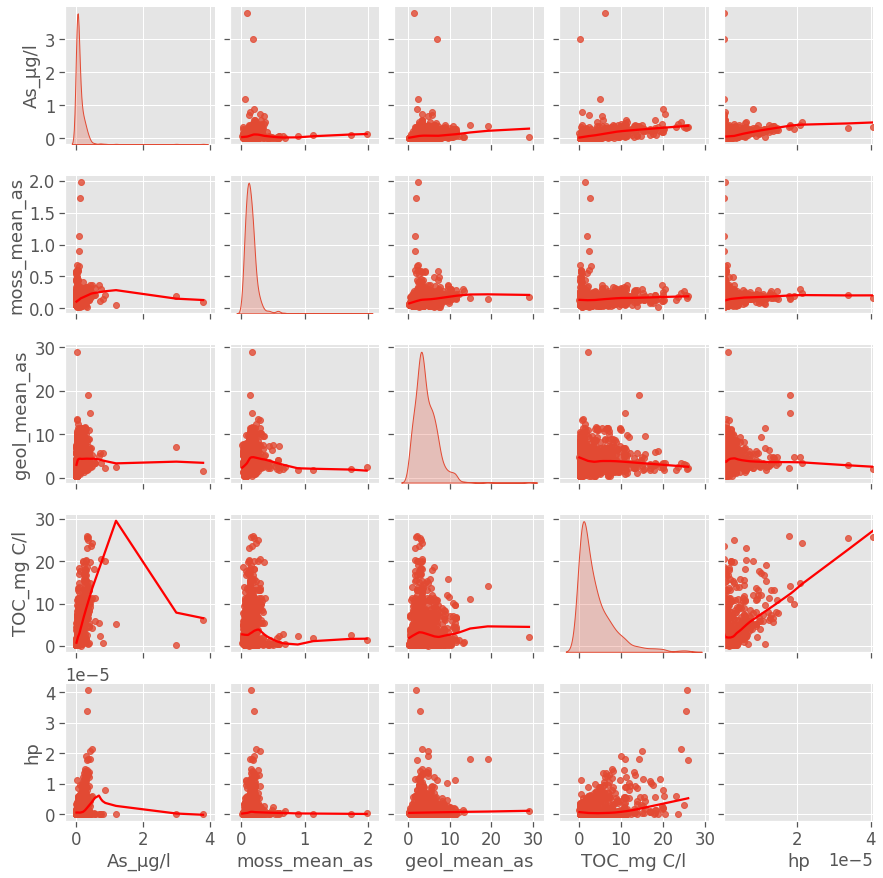

In [14]:
par = "As"

cols = [
    f"{par}_µg/l",
    f"moss_mean_{par.lower()}",
    f"geol_mean_{par.lower()}",
    "TOC_mg C/l",
    "hp",
]
reg_df = df[cols].copy()

with sn.plotting_context("notebook", font_scale=1.5):
    sn.pairplot(
        reg_df,
        kind="reg",
        diag_kind="kde",
        plot_kws=dict(lowess=True, line_kws=dict(color="red")),
    )

Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                As_µg/l   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     242.1
Date:                Mon, 16 Nov 2020   Prob (F-statistic):          5.25e-145
Time:                        14:47:04   Log-Likelihood:                 1134.7
No. Observations:                 995   AIC:                            -2259.
Df Residuals:                     990   BIC:                            -2235.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fc06d2bef70>,
 StandardScaler())

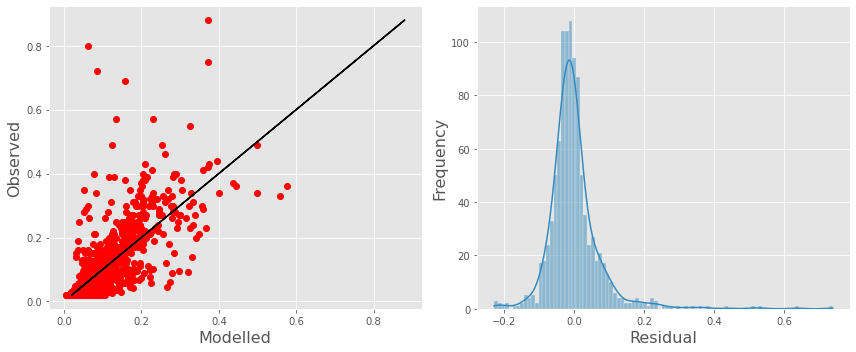

In [15]:
thresh = 1
resp_var = f"{par}_µg/l"
exp_vars = [f"moss_mean_{par.lower()}", f"geol_mean_{par.lower()}", "TOC_mg C/l", "hp"]

reg_df = reg_df[reg_df[f"{par}_µg/l"] < thresh].reset_index(drop=True)
utils.best_subsets_ols_regression(reg_df, resp_var, exp_vars, standardise=True)

### 7.2. Cr

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


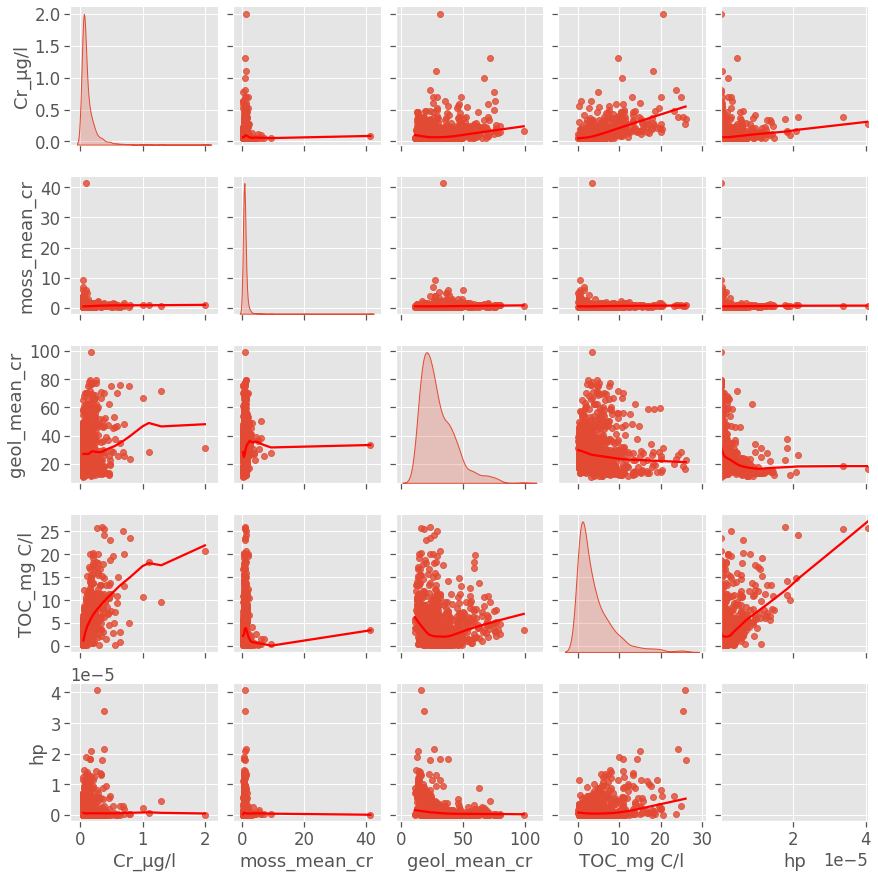

In [16]:
par = "Cr"

cols = [
    f"{par}_µg/l",
    f"moss_mean_{par.lower()}",
    f"geol_mean_{par.lower()}",
    "TOC_mg C/l",
    "hp",
]
reg_df = df[cols].copy()

with sn.plotting_context("notebook", font_scale=1.5):
    sn.pairplot(
        reg_df,
        kind="reg",
        diag_kind="kde",
        plot_kws=dict(lowess=True, line_kws=dict(color="red")),
    )

Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                Cr_µg/l   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     306.2
Date:                Mon, 16 Nov 2020   Prob (F-statistic):          1.37e-140
Time:                        14:47:10   Log-Likelihood:                 1131.6
No. Observations:                 994   AIC:                            -2255.
Df Residuals:                     990   BIC:                            -2236.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fc0828d2520>,
 StandardScaler())

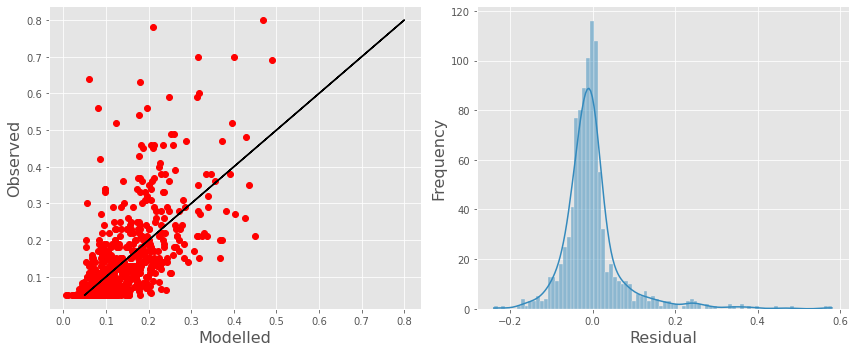

In [17]:
thresh = 1
resp_var = f"{par}_µg/l"
exp_vars = [f"moss_mean_{par.lower()}", f"geol_mean_{par.lower()}", "TOC_mg C/l", "hp"]

reg_df = reg_df[reg_df[f"{par}_µg/l"] < thresh].reset_index(drop=True)
utils.best_subsets_ols_regression(reg_df, resp_var, exp_vars, standardise=True)

### 7.3. Cu

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


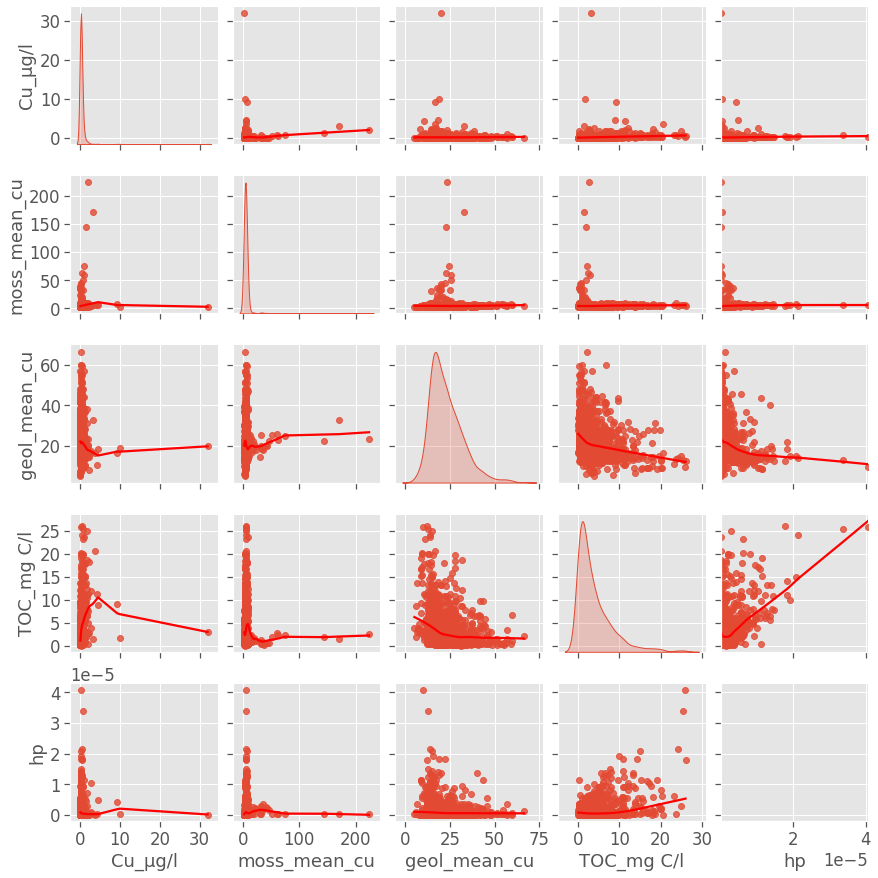

In [18]:
par = "Cu"

cols = [
    f"{par}_µg/l",
    f"moss_mean_{par.lower()}",
    f"geol_mean_{par.lower()}",
    "TOC_mg C/l",
    "hp",
]
reg_df = df[cols].copy()

with sn.plotting_context("notebook", font_scale=1.5):
    sn.pairplot(
        reg_df,
        kind="reg",
        diag_kind="kde",
        plot_kws=dict(lowess=True, line_kws=dict(color="red")),
    )

Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                Cu_µg/l   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     89.03
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           1.16e-64
Time:                        14:47:17   Log-Likelihood:                -353.39
No. Observations:                 995   AIC:                             716.8
Df Residuals:                     990   BIC:                             741.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fc0827964c0>,
 StandardScaler())

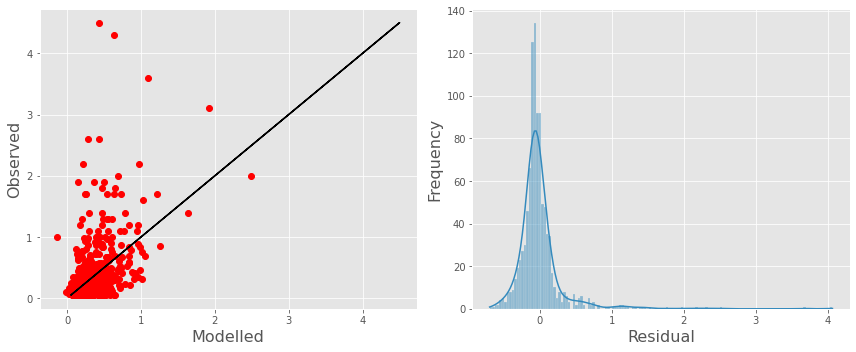

In [19]:
thresh = 7
resp_var = f"{par}_µg/l"
exp_vars = [f"moss_mean_{par.lower()}", f"geol_mean_{par.lower()}", "TOC_mg C/l", "hp"]

reg_df = reg_df[reg_df[f"{par}_µg/l"] < thresh].reset_index(drop=True)
utils.best_subsets_ols_regression(reg_df, resp_var, exp_vars, standardise=True)

### 7.4. Ni

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


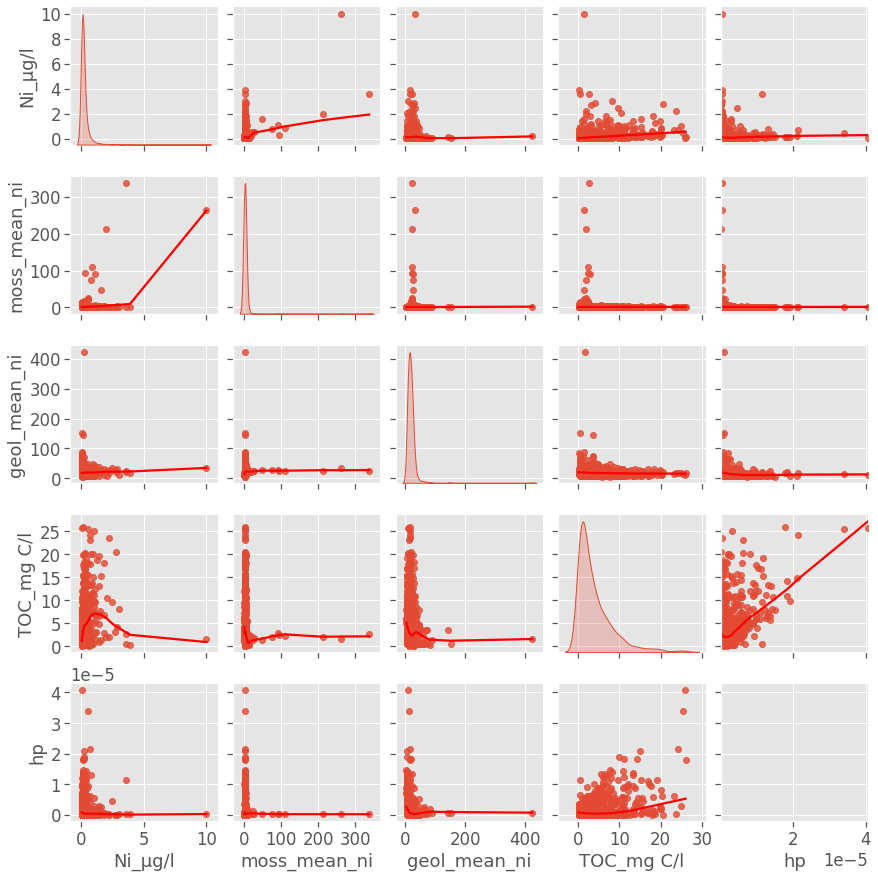

In [20]:
par = "Ni"

cols = [
    f"{par}_µg/l",
    f"moss_mean_{par.lower()}",
    f"geol_mean_{par.lower()}",
    "TOC_mg C/l",
    "hp",
]
reg_df = df[cols].copy()

with sn.plotting_context("notebook", font_scale=1.5):
    sn.pairplot(
        reg_df,
        kind="reg",
        diag_kind="kde",
        plot_kws=dict(lowess=True, line_kws=dict(color="red")),
    )

Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                Ni_µg/l   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     111.8
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           2.37e-62
Time:                        14:47:24   Log-Likelihood:                -307.81
No. Observations:                 997   AIC:                             623.6
Df Residuals:                     993   BIC:                             643.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fc06d929b20>,
 StandardScaler())

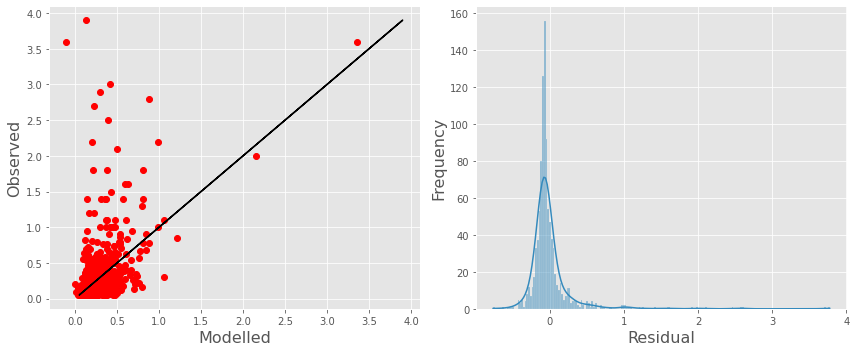

In [21]:
thresh = 4
resp_var = f"{par}_µg/l"
exp_vars = [f"moss_mean_{par.lower()}", f"geol_mean_{par.lower()}", "TOC_mg C/l", "hp"]

reg_df = reg_df[reg_df[f"{par}_µg/l"] < thresh].reset_index(drop=True)
utils.best_subsets_ols_regression(reg_df, resp_var, exp_vars, standardise=True)

### 7.5. Pb

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


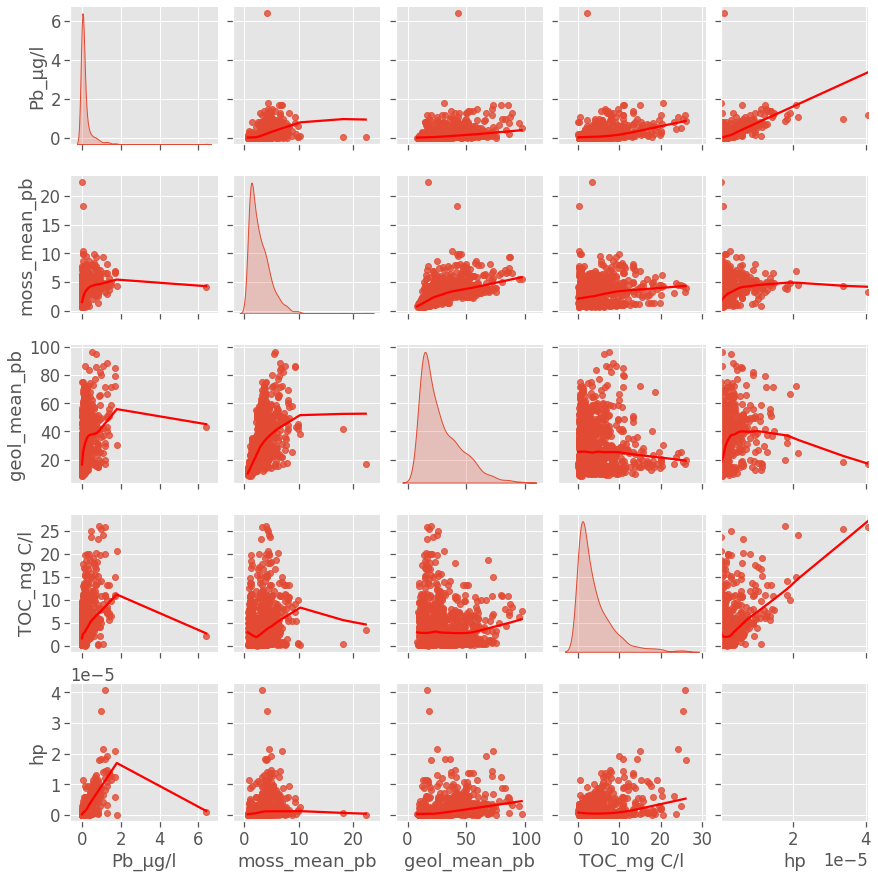

In [22]:
par = "Pb"

cols = [
    f"{par}_µg/l",
    f"moss_mean_{par.lower()}",
    f"geol_mean_{par.lower()}",
    "TOC_mg C/l",
    "hp",
]
reg_df = df[cols].copy()

with sn.plotting_context("notebook", font_scale=1.5):
    sn.pairplot(
        reg_df,
        kind="reg",
        diag_kind="kde",
        plot_kws=dict(lowess=True, line_kws=dict(color="red")),
    )

Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                Pb_µg/l   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     590.3
Date:                Mon, 16 Nov 2020   Prob (F-statistic):          1.50e-260
Time:                        14:47:31   Log-Likelihood:                 483.76
No. Observations:                 997   AIC:                            -957.5
Df Residuals:                     992   BIC:                            -933.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

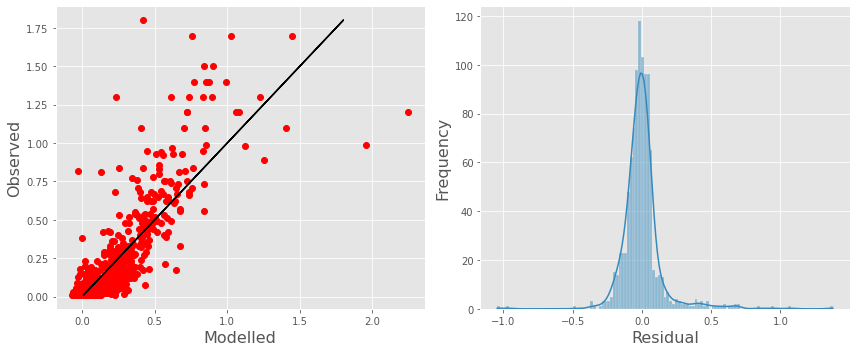

In [23]:
thresh = 5
resp_var = f"{par}_µg/l"
exp_vars = [f"moss_mean_{par.lower()}", f"geol_mean_{par.lower()}", "TOC_mg C/l", "hp"]

reg_df = reg_df[reg_df[f"{par}_µg/l"] < thresh].reset_index(drop=True)
utils.best_subsets_ols_regression(reg_df, resp_var, exp_vars, standardise=True)

png_path = r"../plots/metals/1k_lakes/ols_regression_pb.png"
plt.savefig(png_path, dpi=300, bbox_inches="tight")

### 7.6. Zn

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


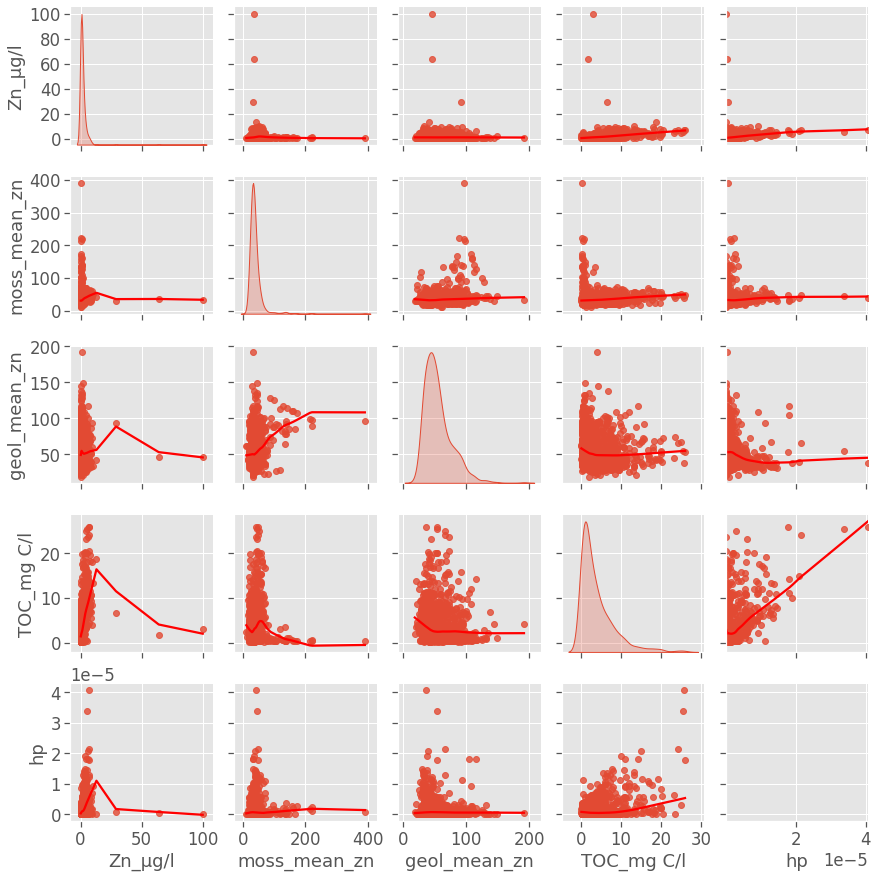

In [24]:
par = "Zn"

cols = [
    f"{par}_µg/l",
    f"moss_mean_{par.lower()}",
    f"geol_mean_{par.lower()}",
    "TOC_mg C/l",
    "hp",
]
reg_df = df[cols].copy()

with sn.plotting_context("notebook", font_scale=1.5):
    sn.pairplot(
        reg_df,
        kind="reg",
        diag_kind="kde",
        plot_kws=dict(lowess=True, line_kws=dict(color="red")),
    )

Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                Zn_µg/l   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     196.3
Date:                Mon, 16 Nov 2020   Prob (F-statistic):          6.71e-124
Time:                        14:47:38   Log-Likelihood:                -1703.2
No. Observations:                 995   AIC:                             3416.
Df Residuals:                     990   BIC:                             3441.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fc06e340130>,
 StandardScaler())

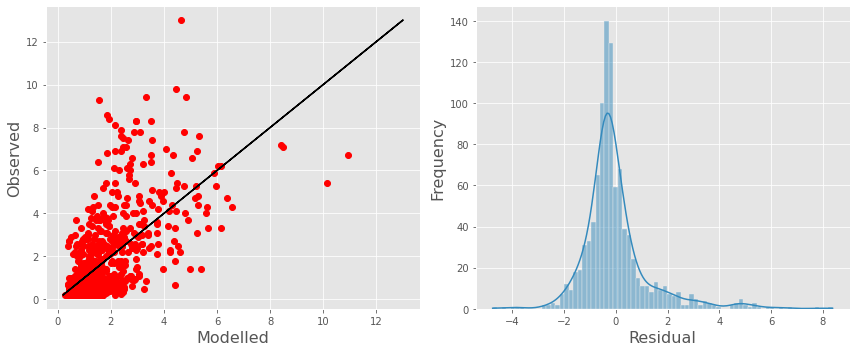

In [25]:
thresh = 20
resp_var = f"{par}_µg/l"
exp_vars = [f"moss_mean_{par.lower()}", f"geol_mean_{par.lower()}", "TOC_mg C/l", "hp"]

reg_df = reg_df[reg_df[f"{par}_µg/l"] < thresh].reset_index(drop=True)
utils.best_subsets_ols_regression(reg_df, resp_var, exp_vars, standardise=True)

## 8. Summary

The relationships identified above are much more robust than those obtained using the 1995 1000 Lakes dataset: all relationships are highly statistically significant and most  are physically plausible. However, the explanatory power for several of the metals is poor (i.e. the effect size is small/negligible). Furthermore, in most cases the effects of **other water chemistry parameters (especially TOC concentration) are more important than either the moss or geochemistry variables**. This is problematic, because TEOTIL enforces a simple conceptual framework that is incapable of representing such "process-based" or "mechanistic" effects. 

**Note:** Similar problems have been documented previously for the original TEOTIL model when simulating phosphorus: because a significant fraction of the P-load is typically bound to particulates, the model performs poorly compared to nitrogen (where most of the flux is dissolved).

This notebook highlights the following problems/challenges with developing TEOTIL2 Metals:

 * The geochemistry dataset only includes values for **six out of eight** metals of interest
 
 * Although the moss suveys take place every five years, the number of data points has reduced substantially since 2005. Data for Hg are missing from the 1990 survey and, furthermore, in surveys prior to 2005 detection limits were substantially higher (similar to the 1995 1000 Lakes survey)
 
 * The statistical analysis required to identify export coefficients for the model identifies **significant but weak** relationships, where the best predictors are usually other water chemistry variables (pH and TOC) and **not** the moss or geochemistry datasets. Since we do not have national scale datasets of pH and TOC through time (the "1000 Lakes" are 20 years apart), it is not possible to use these relationships effectively. Furthermore, relationships restricted to using only the moss and geochemistry datasets are *very* poor
 
With these points in mind, **I do not think it is sensible to continue development of TEOTIL2 Metals in this direction**, at least for the moment. Instead, I will explore an alternative solution that makes better use of the 2019 1000 Lakes dataset.